In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [7]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_pred = tf.argmax(input=actions_logits, axis=1, output_type=actions.dtype)
    mask_notequal = tf.not_equal(x=actions_pred, y=actions)
    gQs_notequal = tf.boolean_mask(mask=mask_notequal, tensor=gQs)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_notequal, # GAN
                                                                    labels=tf.zeros_like(gQs_notequal))) # 0-1
    mask_equal = tf.equal(x=actions_pred, y=actions)
    gQs_equal = tf.boolean_mask(mask=mask_equal, tensor=gQs)
    #     rates_equal = tf.boolean_mask(mask=mask_equal, tensor=rates)
    #     dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
    #                                                                     labels=rates_equal)) # 0-1
    #     targetQs_equal = tf.boolean_mask(mask=mask_equal, tensor=targetQs)
    #     dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
    #                                                                     labels=tf.nn.sigmoid(targetQs_equal))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ, gQs_notequal, gQs_equal

In [8]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ, self.gQs_notequal, self.gQs_equal = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [10]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [11]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [12]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [13]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

/home/arasdar/miniconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [14]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [15]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _, glossQ, dlossQ = sess.run([model.d_loss, model.d_opt, 
                                                 model.g_lossQ, model.d_lossQ],
                                                feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.rates: rates})
            gloss, _, gQs_notequal, gQs_equal = sess.run([model.g_loss, model.g_opt, 
                                                          model.gQs_notequal, model.gQs_equal], 
                                              feed_dict = {model.states: states, 
                                                           model.actions: actions,
                                                           model.targetQs: targetQs, 
                                                           model.rates: rates})
            #if len(gQs_nonequal) != len(nextQs):
            # if dloss is np.nan:            
            #     print(gQs_notequal.shape, gQs_notequal.dtype)
            #     print(gQs_equal.shape, gQs_equal.dtype)
            #     print(nextQs.shape)
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:19.0000 R:19.0000 rate:0.0380 gloss:1.3858 dloss:2.0559 glossQ:1.0011 dlossQ:1.3932 exploreP:0.9981
Episode:1 meanR:18.0000 R:17.0000 rate:0.0340 gloss:1.3832 dloss:2.0477 glossQ:1.0019 dlossQ:1.3962 exploreP:0.9964
Episode:2 meanR:16.6667 R:14.0000 rate:0.0280 gloss:1.3819 dloss:2.0403 glossQ:1.0025 dlossQ:1.3764 exploreP:0.9951
Episode:3 meanR:16.2500 R:15.0000 rate:0.0300 gloss:1.3794 dloss:2.0332 glossQ:1.0088 dlossQ:1.3714 exploreP:0.9936
Episode:4 meanR:16.4000 R:17.0000 rate:0.0340 gloss:1.3775 dloss:2.0271 glossQ:1.0042 dlossQ:1.3526 exploreP:0.9919
Episode:5 meanR:16.5000 R:17.0000 rate:0.0340 gloss:1.3744 dloss:2.0106 glossQ:1.0069 dlossQ:1.3410 exploreP:0.9902
Episode:6 meanR:21.4286 R:51.0000 rate:0.1020 gloss:1.3701 dloss:1.9940 glossQ:1.0082 dlossQ:1.3036 exploreP:0.9853
Episode:7 meanR:20.2500 R:12.0000 rate:0.0240 gloss:1.3593 dloss:1.9588 glossQ:1.0155 dlossQ:1.2414 exploreP:0.9841
Episode:8 meanR:20.2222 R:20.0000 rate:0.0400 gloss:1.3612 dloss:nan glo

Episode:71 meanR:21.7361 R:15.0000 rate:0.0300 gloss:1.2143 dloss:1.4284 glossQ:1.4122 dlossQ:1.2910 exploreP:0.8566
Episode:72 meanR:21.5753 R:10.0000 rate:0.0200 gloss:1.2299 dloss:1.4520 glossQ:1.0937 dlossQ:1.0142 exploreP:0.8557
Episode:73 meanR:21.5270 R:18.0000 rate:0.0360 gloss:1.1829 dloss:1.3955 glossQ:1.1338 dlossQ:1.0869 exploreP:0.8542
Episode:74 meanR:21.4800 R:18.0000 rate:0.0360 gloss:1.1967 dloss:1.4393 glossQ:1.1499 dlossQ:1.1714 exploreP:0.8527
Episode:75 meanR:21.4868 R:22.0000 rate:0.0440 gloss:1.1807 dloss:1.4073 glossQ:1.1244 dlossQ:1.1362 exploreP:0.8508
Episode:76 meanR:21.5844 R:29.0000 rate:0.0580 gloss:1.1934 dloss:1.4191 glossQ:1.1272 dlossQ:1.1702 exploreP:0.8484
Episode:77 meanR:21.4872 R:14.0000 rate:0.0280 gloss:1.1844 dloss:1.4168 glossQ:1.1177 dlossQ:1.1965 exploreP:0.8472
Episode:78 meanR:21.3671 R:12.0000 rate:0.0240 gloss:1.1946 dloss:1.4236 glossQ:1.1430 dlossQ:1.2597 exploreP:0.8462
Episode:79 meanR:21.2750 R:14.0000 rate:0.0280 gloss:1.1698 dlos

Episode:141 meanR:17.9600 R:13.0000 rate:0.0260 gloss:1.1051 dloss:1.2452 glossQ:1.1460 dlossQ:0.9932 exploreP:0.7639
Episode:142 meanR:18.1200 R:32.0000 rate:0.0640 gloss:1.1110 dloss:1.2550 glossQ:1.1953 dlossQ:1.0409 exploreP:0.7615
Episode:143 meanR:18.0300 R:25.0000 rate:0.0500 gloss:1.1110 dloss:1.2546 glossQ:1.1691 dlossQ:1.0216 exploreP:0.7596
Episode:144 meanR:17.7900 R:23.0000 rate:0.0460 gloss:1.0857 dloss:1.2259 glossQ:1.1642 dlossQ:1.0042 exploreP:0.7579
Episode:145 meanR:17.6400 R:13.0000 rate:0.0260 gloss:1.1189 dloss:1.2565 glossQ:1.1543 dlossQ:0.9970 exploreP:0.7570
Episode:146 meanR:17.6000 R:20.0000 rate:0.0400 gloss:1.1333 dloss:1.2722 glossQ:1.3147 dlossQ:1.1508 exploreP:0.7555
Episode:147 meanR:17.3300 R:12.0000 rate:0.0240 gloss:1.1319 dloss:1.2662 glossQ:1.1388 dlossQ:0.9592 exploreP:0.7546
Episode:148 meanR:17.2100 R:10.0000 rate:0.0200 gloss:1.0979 dloss:1.2354 glossQ:1.1656 dlossQ:0.9904 exploreP:0.7538
Episode:149 meanR:17.4200 R:32.0000 rate:0.0640 gloss:1.

Episode:211 meanR:16.4200 R:27.0000 rate:0.0540 gloss:1.1212 dloss:1.2890 glossQ:1.1580 dlossQ:1.0709 exploreP:0.6830
Episode:212 meanR:16.4300 R:15.0000 rate:0.0300 gloss:1.1534 dloss:1.3167 glossQ:1.1462 dlossQ:1.0645 exploreP:0.6820
Episode:213 meanR:16.1900 R:18.0000 rate:0.0360 gloss:1.1380 dloss:1.3048 glossQ:1.1400 dlossQ:1.0508 exploreP:0.6808
Episode:214 meanR:16.2500 R:18.0000 rate:0.0360 gloss:1.1485 dloss:1.3092 glossQ:1.1450 dlossQ:1.0298 exploreP:0.6795
Episode:215 meanR:16.2100 R:16.0000 rate:0.0320 gloss:1.1305 dloss:1.2910 glossQ:1.1492 dlossQ:1.0376 exploreP:0.6785
Episode:216 meanR:16.2500 R:20.0000 rate:0.0400 gloss:1.1270 dloss:1.2882 glossQ:1.1840 dlossQ:1.0722 exploreP:0.6771
Episode:217 meanR:16.1800 R:18.0000 rate:0.0360 gloss:1.1265 dloss:1.2901 glossQ:1.1443 dlossQ:1.0354 exploreP:0.6759
Episode:218 meanR:16.1700 R:11.0000 rate:0.0220 gloss:1.1271 dloss:1.2900 glossQ:1.1605 dlossQ:1.0344 exploreP:0.6752
Episode:219 meanR:16.1700 R:10.0000 rate:0.0200 gloss:1.

Episode:281 meanR:13.6100 R:9.0000 rate:0.0180 gloss:1.0908 dloss:1.2357 glossQ:1.2254 dlossQ:1.0698 exploreP:0.6235
Episode:282 meanR:13.6100 R:10.0000 rate:0.0200 gloss:1.1208 dloss:1.2681 glossQ:1.1428 dlossQ:0.9916 exploreP:0.6228
Episode:283 meanR:13.5900 R:10.0000 rate:0.0200 gloss:1.1108 dloss:1.2626 glossQ:1.1778 dlossQ:1.0397 exploreP:0.6222
Episode:284 meanR:13.5400 R:9.0000 rate:0.0180 gloss:1.1069 dloss:1.2580 glossQ:1.1700 dlossQ:1.0426 exploreP:0.6217
Episode:285 meanR:13.5300 R:10.0000 rate:0.0200 gloss:1.1120 dloss:1.2624 glossQ:1.1651 dlossQ:1.0420 exploreP:0.6211
Episode:286 meanR:13.6000 R:15.0000 rate:0.0300 gloss:1.1745 dloss:1.3228 glossQ:1.6648 dlossQ:1.5237 exploreP:0.6202
Episode:287 meanR:13.5900 R:14.0000 rate:0.0280 gloss:1.1099 dloss:1.2605 glossQ:1.1612 dlossQ:1.0262 exploreP:0.6193
Episode:288 meanR:13.5200 R:11.0000 rate:0.0220 gloss:1.1308 dloss:1.2828 glossQ:1.1549 dlossQ:1.0381 exploreP:0.6186
Episode:289 meanR:13.5000 R:12.0000 rate:0.0240 gloss:1.10

Episode:351 meanR:12.8700 R:11.0000 rate:0.0220 gloss:1.0700 dloss:1.2028 glossQ:1.2216 dlossQ:1.0432 exploreP:0.5708
Episode:352 meanR:12.9700 R:20.0000 rate:0.0400 gloss:1.0849 dloss:1.2192 glossQ:1.2066 dlossQ:1.0342 exploreP:0.5696
Episode:353 meanR:12.9900 R:15.0000 rate:0.0300 gloss:1.1108 dloss:1.2436 glossQ:1.2020 dlossQ:1.0268 exploreP:0.5688
Episode:354 meanR:12.9800 R:10.0000 rate:0.0200 gloss:1.1027 dloss:1.2407 glossQ:1.1626 dlossQ:1.0034 exploreP:0.5682
Episode:355 meanR:12.8800 R:9.0000 rate:0.0180 gloss:1.0857 dloss:1.2241 glossQ:1.1901 dlossQ:1.0321 exploreP:0.5677
Episode:356 meanR:12.9000 R:13.0000 rate:0.0260 gloss:1.1126 dloss:1.2493 glossQ:1.1712 dlossQ:1.0050 exploreP:0.5670
Episode:357 meanR:12.8900 R:12.0000 rate:0.0240 gloss:1.1180 dloss:1.2615 glossQ:1.1802 dlossQ:1.0280 exploreP:0.5664
Episode:358 meanR:12.8100 R:10.0000 rate:0.0200 gloss:1.0932 dloss:1.2352 glossQ:1.1935 dlossQ:1.0388 exploreP:0.5658
Episode:359 meanR:12.8700 R:16.0000 rate:0.0320 gloss:1.1

Episode:421 meanR:12.5600 R:8.0000 rate:0.0160 gloss:1.1440 dloss:1.2841 glossQ:1.1590 dlossQ:0.9720 exploreP:0.5246
Episode:422 meanR:12.5700 R:10.0000 rate:0.0200 gloss:1.0990 dloss:1.2451 glossQ:1.1851 dlossQ:1.0130 exploreP:0.5241
Episode:423 meanR:12.6200 R:16.0000 rate:0.0320 gloss:1.0991 dloss:1.2488 glossQ:1.1784 dlossQ:1.0156 exploreP:0.5233
Episode:424 meanR:12.6100 R:13.0000 rate:0.0260 gloss:1.1427 dloss:1.2846 glossQ:1.1619 dlossQ:0.9884 exploreP:0.5226
Episode:425 meanR:12.5800 R:10.0000 rate:0.0200 gloss:1.1136 dloss:1.2586 glossQ:1.1647 dlossQ:1.0080 exploreP:0.5221
Episode:426 meanR:12.4300 R:12.0000 rate:0.0240 gloss:1.1213 dloss:1.2654 glossQ:1.1932 dlossQ:1.0393 exploreP:0.5215
Episode:427 meanR:12.3700 R:12.0000 rate:0.0240 gloss:1.1157 dloss:1.2570 glossQ:1.2860 dlossQ:1.1143 exploreP:0.5209
Episode:428 meanR:12.4000 R:13.0000 rate:0.0260 gloss:1.1162 dloss:1.2634 glossQ:1.1693 dlossQ:1.0142 exploreP:0.5202
Episode:429 meanR:12.3800 R:9.0000 rate:0.0180 gloss:1.10

Episode:491 meanR:11.8300 R:11.0000 rate:0.0220 gloss:1.1478 dloss:1.2879 glossQ:1.1539 dlossQ:0.9957 exploreP:0.4840
Episode:492 meanR:11.8200 R:11.0000 rate:0.0220 gloss:1.1108 dloss:1.2537 glossQ:1.1747 dlossQ:1.0114 exploreP:0.4835
Episode:493 meanR:11.8500 R:13.0000 rate:0.0260 gloss:1.1049 dloss:1.2498 glossQ:1.1859 dlossQ:1.0434 exploreP:0.4829
Episode:494 meanR:11.9700 R:22.0000 rate:0.0440 gloss:1.1281 dloss:1.2702 glossQ:1.1596 dlossQ:1.0004 exploreP:0.4818
Episode:495 meanR:11.9600 R:10.0000 rate:0.0200 gloss:1.1108 dloss:1.2498 glossQ:1.1735 dlossQ:0.9975 exploreP:0.4814
Episode:496 meanR:11.9000 R:9.0000 rate:0.0180 gloss:1.1016 dloss:1.2421 glossQ:1.1647 dlossQ:1.0001 exploreP:0.4809
Episode:497 meanR:11.8500 R:11.0000 rate:0.0220 gloss:1.0836 dloss:1.2253 glossQ:1.1951 dlossQ:1.0268 exploreP:0.4804
Episode:498 meanR:11.8600 R:12.0000 rate:0.0240 gloss:1.1322 dloss:1.2682 glossQ:1.2357 dlossQ:1.0605 exploreP:0.4798
Episode:499 meanR:11.8700 R:12.0000 rate:0.0240 gloss:1.1

Episode:561 meanR:11.5600 R:13.0000 rate:0.0260 gloss:1.1076 dloss:1.2583 glossQ:1.1761 dlossQ:1.0334 exploreP:0.4469
Episode:562 meanR:11.5400 R:9.0000 rate:0.0180 gloss:1.1322 dloss:1.2795 glossQ:1.1648 dlossQ:1.0279 exploreP:0.4465
Episode:563 meanR:11.5800 R:12.0000 rate:0.0240 gloss:1.0871 dloss:1.2370 glossQ:1.2101 dlossQ:1.0684 exploreP:0.4459
Episode:564 meanR:11.5400 R:12.0000 rate:0.0240 gloss:1.1178 dloss:1.2693 glossQ:1.1722 dlossQ:1.0299 exploreP:0.4454
Episode:565 meanR:11.5300 R:9.0000 rate:0.0180 gloss:1.0775 dloss:1.2256 glossQ:1.2171 dlossQ:1.0753 exploreP:0.4450
Episode:566 meanR:11.4800 R:10.0000 rate:0.0200 gloss:1.1215 dloss:1.2689 glossQ:1.2043 dlossQ:1.0726 exploreP:0.4446
Episode:567 meanR:11.5300 R:15.0000 rate:0.0300 gloss:1.1076 dloss:1.2549 glossQ:1.1827 dlossQ:1.0446 exploreP:0.4439
Episode:568 meanR:11.5300 R:10.0000 rate:0.0200 gloss:1.1317 dloss:1.2802 glossQ:1.2264 dlossQ:1.0941 exploreP:0.4435
Episode:569 meanR:11.5400 R:13.0000 rate:0.0260 gloss:1.12

Episode:631 meanR:11.2000 R:10.0000 rate:0.0200 gloss:1.1112 dloss:1.2570 glossQ:1.1793 dlossQ:1.0448 exploreP:0.4144
Episode:632 meanR:11.1800 R:9.0000 rate:0.0180 gloss:1.1189 dloss:1.2643 glossQ:1.1727 dlossQ:1.0321 exploreP:0.4141
Episode:633 meanR:11.2200 R:13.0000 rate:0.0260 gloss:1.1127 dloss:1.2582 glossQ:1.1626 dlossQ:1.0329 exploreP:0.4136
Episode:634 meanR:11.2000 R:8.0000 rate:0.0160 gloss:1.1129 dloss:1.2612 glossQ:1.2379 dlossQ:1.1342 exploreP:0.4132
Episode:635 meanR:11.1800 R:10.0000 rate:0.0200 gloss:1.1068 dloss:1.2533 glossQ:1.1687 dlossQ:1.0431 exploreP:0.4128
Episode:636 meanR:11.2000 R:14.0000 rate:0.0280 gloss:1.0900 dloss:1.2377 glossQ:1.1963 dlossQ:1.0724 exploreP:0.4123
Episode:637 meanR:11.1500 R:12.0000 rate:0.0240 gloss:1.1003 dloss:1.2468 glossQ:1.1876 dlossQ:1.0572 exploreP:0.4118
Episode:638 meanR:11.0900 R:9.0000 rate:0.0180 gloss:1.1059 dloss:1.2476 glossQ:1.1730 dlossQ:1.0376 exploreP:0.4114
Episode:639 meanR:11.1400 R:16.0000 rate:0.0320 gloss:1.127

Episode:701 meanR:11.3800 R:10.0000 rate:0.0200 gloss:1.1112 dloss:1.2565 glossQ:1.1700 dlossQ:1.0305 exploreP:0.3827
Episode:702 meanR:11.3400 R:10.0000 rate:0.0200 gloss:1.1043 dloss:1.2496 glossQ:1.2037 dlossQ:1.0570 exploreP:0.3824
Episode:703 meanR:11.3300 R:10.0000 rate:0.0200 gloss:1.1101 dloss:1.2581 glossQ:1.2595 dlossQ:1.1214 exploreP:0.3820
Episode:704 meanR:11.3100 R:9.0000 rate:0.0180 gloss:1.1387 dloss:1.2836 glossQ:1.1674 dlossQ:1.0206 exploreP:0.3817
Episode:705 meanR:11.3400 R:14.0000 rate:0.0280 gloss:1.1310 dloss:1.2743 glossQ:1.1676 dlossQ:1.0163 exploreP:0.3811
Episode:706 meanR:11.3200 R:8.0000 rate:0.0160 gloss:1.1198 dloss:1.2658 glossQ:1.1780 dlossQ:1.0233 exploreP:0.3809
Episode:707 meanR:11.3300 R:12.0000 rate:0.0240 gloss:1.1233 dloss:1.2727 glossQ:1.2421 dlossQ:1.1154 exploreP:0.3804
Episode:708 meanR:11.3400 R:12.0000 rate:0.0240 gloss:1.1266 dloss:1.2755 glossQ:1.2082 dlossQ:1.0598 exploreP:0.3800
Episode:709 meanR:11.3400 R:9.0000 rate:0.0180 gloss:1.091

Episode:771 meanR:10.9500 R:10.0000 rate:0.0200 gloss:1.0714 dloss:1.2111 glossQ:1.2210 dlossQ:1.0432 exploreP:0.3560
Episode:772 meanR:11.0100 R:17.0000 rate:0.0340 gloss:1.0935 dloss:1.2305 glossQ:1.1977 dlossQ:1.0117 exploreP:0.3554
Episode:773 meanR:11.0100 R:10.0000 rate:0.0200 gloss:1.0785 dloss:1.2163 glossQ:1.2034 dlossQ:1.0220 exploreP:0.3551
Episode:774 meanR:11.0000 R:11.0000 rate:0.0220 gloss:1.0669 dloss:1.2080 glossQ:1.2328 dlossQ:1.0714 exploreP:0.3547
Episode:775 meanR:11.0100 R:10.0000 rate:0.0200 gloss:1.0800 dloss:1.2144 glossQ:1.1955 dlossQ:1.0033 exploreP:0.3543
Episode:776 meanR:10.9900 R:10.0000 rate:0.0200 gloss:1.0890 dloss:1.2212 glossQ:1.1925 dlossQ:0.9948 exploreP:0.3540
Episode:777 meanR:10.9400 R:9.0000 rate:0.0180 gloss:1.1188 dloss:1.2500 glossQ:1.3681 dlossQ:1.1911 exploreP:0.3537
Episode:778 meanR:10.9500 R:10.0000 rate:0.0200 gloss:1.0957 dloss:1.2286 glossQ:1.1863 dlossQ:1.0030 exploreP:0.3533
Episode:779 meanR:11.0200 R:17.0000 rate:0.0340 gloss:1.0

Episode:841 meanR:10.8900 R:14.0000 rate:0.0280 gloss:1.0875 dloss:1.2178 glossQ:1.2313 dlossQ:1.0242 exploreP:0.3305
Episode:842 meanR:10.8900 R:9.0000 rate:0.0180 gloss:1.0891 dloss:1.2190 glossQ:1.2184 dlossQ:1.0151 exploreP:0.3303
Episode:843 meanR:10.8600 R:10.0000 rate:0.0200 gloss:1.1113 dloss:1.2417 glossQ:1.1832 dlossQ:0.9855 exploreP:0.3299
Episode:844 meanR:10.8700 R:10.0000 rate:0.0200 gloss:1.0527 dloss:1.1827 glossQ:1.2659 dlossQ:1.0480 exploreP:0.3296
Episode:845 meanR:10.8600 R:9.0000 rate:0.0180 gloss:1.0851 dloss:1.2152 glossQ:1.2173 dlossQ:1.0049 exploreP:0.3293
Episode:846 meanR:10.8400 R:9.0000 rate:0.0180 gloss:1.0625 dloss:1.1902 glossQ:1.2470 dlossQ:1.0275 exploreP:0.3290
Episode:847 meanR:10.8400 R:10.0000 rate:0.0200 gloss:1.0481 dloss:1.1792 glossQ:1.2792 dlossQ:1.0738 exploreP:0.3287
Episode:848 meanR:10.8100 R:12.0000 rate:0.0240 gloss:1.0577 dloss:1.1836 glossQ:1.2408 dlossQ:1.0066 exploreP:0.3283
Episode:849 meanR:10.7500 R:9.0000 rate:0.0180 gloss:1.1143

Episode:911 meanR:10.6600 R:12.0000 rate:0.0240 gloss:1.0938 dloss:1.2188 glossQ:1.1979 dlossQ:0.9472 exploreP:0.3078
Episode:912 meanR:10.6400 R:10.0000 rate:0.0200 gloss:1.0897 dloss:1.2154 glossQ:1.2265 dlossQ:0.9650 exploreP:0.3075
Episode:913 meanR:10.6300 R:11.0000 rate:0.0220 gloss:1.0625 dloss:1.1929 glossQ:1.2905 dlossQ:1.0591 exploreP:0.3072
Episode:914 meanR:10.6600 R:14.0000 rate:0.0280 gloss:1.0738 dloss:1.1978 glossQ:1.2302 dlossQ:0.9708 exploreP:0.3068
Episode:915 meanR:10.6700 R:10.0000 rate:0.0200 gloss:1.1680 dloss:nan glossQ:1.7735 dlossQ:1.5872 exploreP:0.3065
Episode:916 meanR:10.7000 R:14.0000 rate:0.0280 gloss:1.0686 dloss:1.1973 glossQ:1.2088 dlossQ:0.9551 exploreP:0.3060
Episode:917 meanR:10.7000 R:12.0000 rate:0.0240 gloss:1.0683 dloss:1.1917 glossQ:1.2146 dlossQ:0.9398 exploreP:0.3057
Episode:918 meanR:10.6900 R:9.0000 rate:0.0180 gloss:1.0777 dloss:1.1989 glossQ:1.2099 dlossQ:0.9320 exploreP:0.3054
Episode:919 meanR:10.7100 R:13.0000 rate:0.0260 gloss:1.0515

Episode:981 meanR:10.4900 R:10.0000 rate:0.0200 gloss:1.0639 dloss:1.1800 glossQ:1.2102 dlossQ:0.8959 exploreP:0.2867
Episode:982 meanR:10.5100 R:11.0000 rate:0.0220 gloss:1.0772 dloss:1.1902 glossQ:1.2260 dlossQ:0.9168 exploreP:0.2864
Episode:983 meanR:10.5500 R:13.0000 rate:0.0260 gloss:1.0678 dloss:1.1831 glossQ:1.2584 dlossQ:0.9642 exploreP:0.2861
Episode:984 meanR:10.5800 R:12.0000 rate:0.0240 gloss:1.0883 dloss:1.2034 glossQ:1.2644 dlossQ:0.9859 exploreP:0.2857
Episode:985 meanR:10.5600 R:8.0000 rate:0.0160 gloss:1.0812 dloss:1.1866 glossQ:1.2818 dlossQ:0.9451 exploreP:0.2855
Episode:986 meanR:10.5400 R:8.0000 rate:0.0160 gloss:1.0441 dloss:1.1583 glossQ:1.2232 dlossQ:0.9065 exploreP:0.2853
Episode:987 meanR:10.5600 R:11.0000 rate:0.0220 gloss:1.0959 dloss:1.2091 glossQ:1.2034 dlossQ:0.9154 exploreP:0.2850
Episode:988 meanR:10.5100 R:10.0000 rate:0.0200 gloss:1.0864 dloss:1.2020 glossQ:1.2399 dlossQ:0.9650 exploreP:0.2847
Episode:989 meanR:10.4900 R:8.0000 rate:0.0160 gloss:1.059

Episode:1051 meanR:10.5200 R:10.0000 rate:0.0200 gloss:1.0415 dloss:1.1465 glossQ:1.2649 dlossQ:0.9254 exploreP:0.2670
Episode:1052 meanR:10.5200 R:12.0000 rate:0.0240 gloss:1.0325 dloss:1.1334 glossQ:1.2827 dlossQ:0.9147 exploreP:0.2667
Episode:1053 meanR:10.5200 R:10.0000 rate:0.0200 gloss:1.0408 dloss:1.1414 glossQ:1.2345 dlossQ:0.8620 exploreP:0.2664
Episode:1054 meanR:10.5600 R:14.0000 rate:0.0280 gloss:1.0917 dloss:1.1921 glossQ:1.2356 dlossQ:0.8963 exploreP:0.2661
Episode:1055 meanR:10.5700 R:14.0000 rate:0.0280 gloss:1.0401 dloss:1.1410 glossQ:1.2766 dlossQ:0.9230 exploreP:0.2657
Episode:1056 meanR:10.5600 R:10.0000 rate:0.0200 gloss:1.0663 dloss:1.1628 glossQ:1.2361 dlossQ:0.8564 exploreP:0.2655
Episode:1057 meanR:10.5600 R:10.0000 rate:0.0200 gloss:1.0661 dloss:1.1666 glossQ:1.2300 dlossQ:0.8836 exploreP:0.2652
Episode:1058 meanR:10.5500 R:9.0000 rate:0.0180 gloss:1.0288 dloss:1.1333 glossQ:1.3200 dlossQ:0.9715 exploreP:0.2650
Episode:1059 meanR:10.5500 R:10.0000 rate:0.0200 

Episode:1121 meanR:10.4100 R:9.0000 rate:0.0180 gloss:1.0621 dloss:1.1556 glossQ:1.2136 dlossQ:0.8375 exploreP:0.2492
Episode:1122 meanR:10.4100 R:10.0000 rate:0.0200 gloss:1.0538 dloss:1.1463 glossQ:1.1964 dlossQ:0.8085 exploreP:0.2490
Episode:1123 meanR:10.4200 R:11.0000 rate:0.0220 gloss:1.0515 dloss:1.1507 glossQ:1.2607 dlossQ:0.9384 exploreP:0.2487
Episode:1124 meanR:10.4100 R:9.0000 rate:0.0180 gloss:1.0313 dloss:1.1252 glossQ:1.2509 dlossQ:0.8592 exploreP:0.2485
Episode:1125 meanR:10.4200 R:10.0000 rate:0.0200 gloss:1.0020 dloss:1.0980 glossQ:1.2682 dlossQ:0.8718 exploreP:0.2482
Episode:1126 meanR:10.4400 R:12.0000 rate:0.0240 gloss:1.0246 dloss:1.1184 glossQ:1.2756 dlossQ:0.8997 exploreP:0.2480
Episode:1127 meanR:10.4300 R:10.0000 rate:0.0200 gloss:1.0185 dloss:1.1151 glossQ:1.2453 dlossQ:0.8766 exploreP:0.2477
Episode:1128 meanR:10.4300 R:10.0000 rate:0.0200 gloss:1.0198 dloss:1.1150 glossQ:1.2643 dlossQ:0.9052 exploreP:0.2475
Episode:1129 meanR:10.4400 R:11.0000 rate:0.0220 g

Episode:1190 meanR:10.3300 R:10.0000 rate:0.0200 gloss:1.0226 dloss:1.1212 glossQ:1.2643 dlossQ:0.8975 exploreP:0.2327
Episode:1191 meanR:10.3200 R:9.0000 rate:0.0180 gloss:1.0446 dloss:1.1276 glossQ:1.2254 dlossQ:0.7780 exploreP:0.2325
Episode:1192 meanR:10.3400 R:11.0000 rate:0.0220 gloss:1.0436 dloss:1.1539 glossQ:1.2574 dlossQ:0.9994 exploreP:0.2322
Episode:1193 meanR:10.3400 R:11.0000 rate:0.0220 gloss:1.0310 dloss:1.1298 glossQ:1.2324 dlossQ:0.8948 exploreP:0.2320
Episode:1194 meanR:10.3300 R:10.0000 rate:0.0200 gloss:1.0237 dloss:1.1215 glossQ:1.2861 dlossQ:0.9285 exploreP:0.2318
Episode:1195 meanR:10.3500 R:12.0000 rate:0.0240 gloss:1.0647 dloss:1.1632 glossQ:1.2443 dlossQ:0.9272 exploreP:0.2315
Episode:1196 meanR:10.3500 R:10.0000 rate:0.0200 gloss:1.0520 dloss:1.1424 glossQ:1.3314 dlossQ:0.9544 exploreP:0.2313
Episode:1197 meanR:10.3300 R:10.0000 rate:0.0200 gloss:1.0211 dloss:1.1291 glossQ:1.2518 dlossQ:0.9929 exploreP:0.2311
Episode:1198 meanR:10.3100 R:10.0000 rate:0.0200 

Episode:1260 meanR:11.2100 R:12.0000 rate:0.0240 gloss:1.0367 dloss:1.1445 glossQ:1.2454 dlossQ:0.9654 exploreP:0.2154
Episode:1261 meanR:11.2200 R:11.0000 rate:0.0220 gloss:1.0178 dloss:1.1198 glossQ:1.2216 dlossQ:0.9048 exploreP:0.2152
Episode:1262 meanR:11.2600 R:13.0000 rate:0.0260 gloss:1.0235 dloss:1.1310 glossQ:1.2665 dlossQ:0.9640 exploreP:0.2149
Episode:1263 meanR:11.2900 R:15.0000 rate:0.0300 gloss:1.0593 dloss:1.1831 glossQ:1.3338 dlossQ:1.1685 exploreP:0.2146
Episode:1264 meanR:11.3900 R:20.0000 rate:0.0400 gloss:1.0358 dloss:1.1498 glossQ:1.2336 dlossQ:1.0113 exploreP:0.2142
Episode:1265 meanR:11.4300 R:14.0000 rate:0.0280 gloss:1.0496 dloss:1.1514 glossQ:1.2593 dlossQ:0.9305 exploreP:0.2139
Episode:1266 meanR:11.4600 R:14.0000 rate:0.0280 gloss:1.0396 dloss:1.1446 glossQ:1.2554 dlossQ:0.9598 exploreP:0.2136
Episode:1267 meanR:11.5200 R:14.0000 rate:0.0280 gloss:1.0617 dloss:1.1563 glossQ:1.2566 dlossQ:0.8894 exploreP:0.2133
Episode:1268 meanR:11.5500 R:13.0000 rate:0.0260

Episode:1329 meanR:14.3000 R:14.0000 rate:0.0280 gloss:1.0661 dloss:1.1764 glossQ:1.2373 dlossQ:0.9948 exploreP:0.1949
Episode:1330 meanR:14.3400 R:15.0000 rate:0.0300 gloss:1.0322 dloss:1.1316 glossQ:1.3949 dlossQ:1.0416 exploreP:0.1946
Episode:1331 meanR:14.3200 R:9.0000 rate:0.0180 gloss:1.0543 dloss:1.1874 glossQ:1.2565 dlossQ:1.1238 exploreP:0.1945
Episode:1332 meanR:14.3500 R:15.0000 rate:0.0300 gloss:1.0218 dloss:1.1225 glossQ:1.2441 dlossQ:0.9016 exploreP:0.1942
Episode:1333 meanR:14.3800 R:13.0000 rate:0.0260 gloss:1.0594 dloss:1.1765 glossQ:1.2289 dlossQ:1.0027 exploreP:0.1939
Episode:1334 meanR:14.4300 R:16.0000 rate:0.0320 gloss:1.1080 dloss:1.2172 glossQ:1.2356 dlossQ:0.9911 exploreP:0.1936
Episode:1335 meanR:14.4400 R:15.0000 rate:0.0300 gloss:1.0479 dloss:1.1775 glossQ:1.2678 dlossQ:1.1359 exploreP:0.1934
Episode:1336 meanR:14.4600 R:13.0000 rate:0.0260 gloss:1.0364 dloss:1.1442 glossQ:1.2316 dlossQ:0.9306 exploreP:0.1931
Episode:1337 meanR:14.5400 R:19.0000 rate:0.0380 

Episode:1398 meanR:16.1600 R:16.0000 rate:0.0320 gloss:1.0401 dloss:1.1667 glossQ:1.2507 dlossQ:1.0683 exploreP:0.1747
Episode:1399 meanR:16.1800 R:18.0000 rate:0.0360 gloss:1.0429 dloss:1.1626 glossQ:1.2710 dlossQ:1.0479 exploreP:0.1744
Episode:1400 meanR:16.2500 R:23.0000 rate:0.0460 gloss:1.0462 dloss:1.1610 glossQ:1.2364 dlossQ:0.9889 exploreP:0.1740
Episode:1401 meanR:16.2600 R:16.0000 rate:0.0320 gloss:1.0585 dloss:1.1722 glossQ:1.2318 dlossQ:0.9973 exploreP:0.1738
Episode:1402 meanR:16.2500 R:11.0000 rate:0.0220 gloss:1.0551 dloss:1.1733 glossQ:1.2107 dlossQ:0.9861 exploreP:0.1736
Episode:1403 meanR:16.3400 R:21.0000 rate:0.0420 gloss:1.0623 dloss:1.1783 glossQ:1.2259 dlossQ:1.0025 exploreP:0.1732
Episode:1404 meanR:16.3600 R:15.0000 rate:0.0300 gloss:1.0561 dloss:1.1840 glossQ:1.2623 dlossQ:1.0854 exploreP:0.1730
Episode:1405 meanR:16.4400 R:20.0000 rate:0.0400 gloss:1.0756 dloss:1.2027 glossQ:1.2555 dlossQ:1.0890 exploreP:0.1727
Episode:1406 meanR:16.5400 R:22.0000 rate:0.0440

Episode:1467 meanR:19.8300 R:19.0000 rate:0.0380 gloss:1.0518 dloss:1.1855 glossQ:1.2904 dlossQ:1.1597 exploreP:0.1525
Episode:1468 meanR:19.9000 R:22.0000 rate:0.0440 gloss:1.0495 dloss:1.1808 glossQ:1.2772 dlossQ:1.1485 exploreP:0.1522
Episode:1469 meanR:20.2000 R:49.0000 rate:0.0980 gloss:1.0616 dloss:1.1926 glossQ:1.2603 dlossQ:1.1244 exploreP:0.1515
Episode:1470 meanR:20.2400 R:23.0000 rate:0.0460 gloss:1.0484 dloss:1.1756 glossQ:1.2617 dlossQ:1.0921 exploreP:0.1512
Episode:1471 meanR:20.3200 R:27.0000 rate:0.0540 gloss:1.0415 dloss:1.1721 glossQ:1.2743 dlossQ:1.1258 exploreP:0.1508
Episode:1472 meanR:20.3800 R:21.0000 rate:0.0420 gloss:1.0392 dloss:1.1669 glossQ:1.2626 dlossQ:1.1374 exploreP:0.1505
Episode:1473 meanR:20.4400 R:22.0000 rate:0.0440 gloss:1.0688 dloss:1.1950 glossQ:1.2452 dlossQ:1.0872 exploreP:0.1502
Episode:1474 meanR:20.5200 R:26.0000 rate:0.0520 gloss:1.0570 dloss:1.1821 glossQ:1.2550 dlossQ:1.0921 exploreP:0.1499
Episode:1475 meanR:20.6000 R:27.0000 rate:0.0540

Episode:1536 meanR:28.3700 R:28.0000 rate:0.0560 gloss:1.0960 dloss:1.2453 glossQ:1.1987 dlossQ:1.1430 exploreP:0.1254
Episode:1537 meanR:28.4500 R:38.0000 rate:0.0760 gloss:1.1206 dloss:1.2744 glossQ:1.2693 dlossQ:1.2511 exploreP:0.1250
Episode:1538 meanR:28.5900 R:32.0000 rate:0.0640 gloss:1.0901 dloss:1.2394 glossQ:1.2025 dlossQ:1.1402 exploreP:0.1246
Episode:1539 meanR:28.6200 R:20.0000 rate:0.0400 gloss:1.1005 dloss:1.2518 glossQ:1.1873 dlossQ:1.1379 exploreP:0.1244
Episode:1540 meanR:28.9700 R:57.0000 rate:0.1140 gloss:1.0817 dloss:1.2307 glossQ:1.2157 dlossQ:1.1682 exploreP:0.1237
Episode:1541 meanR:28.9900 R:31.0000 rate:0.0620 gloss:1.0951 dloss:1.2399 glossQ:1.2077 dlossQ:1.1390 exploreP:0.1234
Episode:1542 meanR:29.0400 R:25.0000 rate:0.0500 gloss:1.0811 dloss:1.2256 glossQ:1.1966 dlossQ:1.1118 exploreP:0.1231
Episode:1543 meanR:29.0600 R:22.0000 rate:0.0440 gloss:1.1056 dloss:1.2531 glossQ:1.1873 dlossQ:1.1212 exploreP:0.1228
Episode:1544 meanR:29.3100 R:45.0000 rate:0.0900

Episode:1605 meanR:37.9500 R:36.0000 rate:0.0720 gloss:1.0534 dloss:nan glossQ:1.2103 dlossQ:0.9668 exploreP:0.0981
Episode:1606 meanR:38.0000 R:42.0000 rate:0.0840 gloss:1.0675 dloss:1.1850 glossQ:1.2135 dlossQ:0.9698 exploreP:0.0977
Episode:1607 meanR:38.2600 R:63.0000 rate:0.1260 gloss:1.0542 dloss:1.1712 glossQ:1.2199 dlossQ:0.9592 exploreP:0.0971
Episode:1608 meanR:38.3800 R:40.0000 rate:0.0800 gloss:1.0768 dloss:1.1895 glossQ:1.2280 dlossQ:0.9553 exploreP:0.0968
Episode:1609 meanR:38.4200 R:32.0000 rate:0.0640 gloss:1.0537 dloss:1.1705 glossQ:1.2251 dlossQ:0.9660 exploreP:0.0965
Episode:1610 meanR:38.5600 R:39.0000 rate:0.0780 gloss:1.0586 dloss:1.1745 glossQ:1.2764 dlossQ:1.0160 exploreP:0.0962
Episode:1611 meanR:39.1100 R:90.0000 rate:0.1800 gloss:1.0727 dloss:1.1890 glossQ:1.2084 dlossQ:0.9588 exploreP:0.0954
Episode:1612 meanR:39.1700 R:37.0000 rate:0.0740 gloss:1.0529 dloss:1.1679 glossQ:1.2254 dlossQ:0.9581 exploreP:0.0951
Episode:1613 meanR:39.0800 R:26.0000 rate:0.0520 gl

Episode:1674 meanR:48.3800 R:54.0000 rate:0.1080 gloss:1.0944 dloss:1.2186 glossQ:1.2129 dlossQ:0.9968 exploreP:0.0720
Episode:1675 meanR:48.5400 R:44.0000 rate:0.0880 gloss:1.0789 dloss:1.2053 glossQ:1.2113 dlossQ:0.9876 exploreP:0.0717
Episode:1676 meanR:48.9600 R:72.0000 rate:0.1440 gloss:1.0700 dloss:1.1959 glossQ:1.2298 dlossQ:1.0057 exploreP:0.0713
Episode:1677 meanR:48.7800 R:40.0000 rate:0.0800 gloss:1.0727 dloss:1.1968 glossQ:1.2130 dlossQ:0.9900 exploreP:0.0711
Episode:1678 meanR:48.9800 R:48.0000 rate:0.0960 gloss:1.0529 dloss:1.1764 glossQ:1.2471 dlossQ:1.0153 exploreP:0.0708
Episode:1679 meanR:48.9900 R:44.0000 rate:0.0880 gloss:1.0730 dloss:1.1956 glossQ:1.2587 dlossQ:1.0271 exploreP:0.0705
Episode:1680 meanR:49.6400 R:93.0000 rate:0.1860 gloss:1.0511 dloss:1.1731 glossQ:1.2501 dlossQ:1.0236 exploreP:0.0699
Episode:1681 meanR:49.7100 R:53.0000 rate:0.1060 gloss:1.0536 dloss:1.1748 glossQ:1.2333 dlossQ:1.0076 exploreP:0.0696
Episode:1682 meanR:49.2500 R:40.0000 rate:0.0800

Episode:1744 meanR:48.0100 R:32.0000 rate:0.0640 gloss:1.0705 dloss:1.1986 glossQ:1.2392 dlossQ:1.0264 exploreP:0.0544
Episode:1745 meanR:47.9700 R:30.0000 rate:0.0600 gloss:1.0710 dloss:1.1980 glossQ:1.2405 dlossQ:1.0430 exploreP:0.0543
Episode:1746 meanR:48.1800 R:59.0000 rate:0.1180 gloss:1.0723 dloss:1.1988 glossQ:1.2547 dlossQ:1.0524 exploreP:0.0540
Episode:1747 meanR:48.1400 R:30.0000 rate:0.0600 gloss:1.1132 dloss:1.2374 glossQ:1.1763 dlossQ:0.9858 exploreP:0.0539
Episode:1748 meanR:47.7500 R:32.0000 rate:0.0640 gloss:1.0751 dloss:1.2069 glossQ:1.2042 dlossQ:1.0177 exploreP:0.0538
Episode:1749 meanR:47.3900 R:31.0000 rate:0.0620 gloss:1.0719 dloss:1.1995 glossQ:1.2366 dlossQ:1.0232 exploreP:0.0536
Episode:1750 meanR:47.2200 R:31.0000 rate:0.0620 gloss:1.0826 dloss:1.2104 glossQ:1.2360 dlossQ:1.0296 exploreP:0.0535
Episode:1751 meanR:47.5200 R:63.0000 rate:0.1260 gloss:1.0594 dloss:1.1852 glossQ:1.2458 dlossQ:1.0215 exploreP:0.0532
Episode:1752 meanR:47.6600 R:42.0000 rate:0.0840

Episode:1814 meanR:49.9400 R:79.0000 rate:0.1580 gloss:1.1114 dloss:1.2458 glossQ:1.1937 dlossQ:1.0210 exploreP:0.0414
Episode:1815 meanR:50.1300 R:60.0000 rate:0.1200 gloss:1.1275 dloss:1.2641 glossQ:1.1934 dlossQ:1.0213 exploreP:0.0413
Episode:1816 meanR:50.1200 R:39.0000 rate:0.0780 gloss:1.0985 dloss:1.2360 glossQ:1.2206 dlossQ:1.0489 exploreP:0.0411
Episode:1817 meanR:50.2800 R:67.0000 rate:0.1340 gloss:1.0934 dloss:1.2311 glossQ:1.2222 dlossQ:1.0396 exploreP:0.0409
Episode:1818 meanR:50.5000 R:48.0000 rate:0.0960 gloss:1.1105 dloss:1.2489 glossQ:1.2011 dlossQ:1.0360 exploreP:0.0408
Episode:1819 meanR:50.5200 R:30.0000 rate:0.0600 gloss:1.0970 dloss:1.2350 glossQ:1.2057 dlossQ:1.0418 exploreP:0.0407
Episode:1820 meanR:50.1100 R:32.0000 rate:0.0640 gloss:1.1193 dloss:1.2589 glossQ:1.2021 dlossQ:1.0441 exploreP:0.0406
Episode:1821 meanR:50.2000 R:42.0000 rate:0.0840 gloss:1.1198 dloss:nan glossQ:1.2970 dlossQ:1.1313 exploreP:0.0405
Episode:1822 meanR:50.5200 R:71.0000 rate:0.1420 gl

Episode:1884 meanR:47.7900 R:84.0000 rate:0.1680 gloss:1.1089 dloss:1.2486 glossQ:1.2043 dlossQ:1.0478 exploreP:0.0324
Episode:1885 meanR:48.3600 R:92.0000 rate:0.1840 gloss:1.0977 dloss:1.2396 glossQ:1.2256 dlossQ:1.0671 exploreP:0.0322
Episode:1886 meanR:48.8500 R:79.0000 rate:0.1580 gloss:1.1019 dloss:nan glossQ:1.2338 dlossQ:1.0626 exploreP:0.0321
Episode:1887 meanR:48.7200 R:32.0000 rate:0.0640 gloss:1.1152 dloss:1.2542 glossQ:1.2362 dlossQ:1.0662 exploreP:0.0320
Episode:1888 meanR:48.9200 R:67.0000 rate:0.1340 gloss:1.1030 dloss:1.2418 glossQ:1.2142 dlossQ:1.0513 exploreP:0.0318
Episode:1889 meanR:49.0300 R:51.0000 rate:0.1020 gloss:1.0995 dloss:1.2405 glossQ:1.2015 dlossQ:1.0588 exploreP:0.0317
Episode:1890 meanR:48.7300 R:26.0000 rate:0.0520 gloss:1.1067 dloss:1.2445 glossQ:1.2176 dlossQ:1.0446 exploreP:0.0317
Episode:1891 meanR:48.8100 R:41.0000 rate:0.0820 gloss:1.0733 dloss:1.2111 glossQ:1.2629 dlossQ:1.0904 exploreP:0.0316
Episode:1892 meanR:49.0200 R:80.0000 rate:0.1600 gl

Episode:1954 meanR:50.2700 R:32.0000 rate:0.0640 gloss:1.1102 dloss:1.2599 glossQ:1.1988 dlossQ:1.0602 exploreP:0.0258
Episode:1955 meanR:50.3500 R:41.0000 rate:0.0820 gloss:1.1412 dloss:1.2858 glossQ:1.1814 dlossQ:1.0457 exploreP:0.0257
Episode:1956 meanR:49.9000 R:29.0000 rate:0.0580 gloss:1.1393 dloss:1.2878 glossQ:1.2013 dlossQ:1.0687 exploreP:0.0256
Episode:1957 meanR:49.8900 R:37.0000 rate:0.0740 gloss:1.1171 dloss:1.2655 glossQ:1.2049 dlossQ:1.0621 exploreP:0.0256
Episode:1958 meanR:49.9700 R:37.0000 rate:0.0740 gloss:1.1209 dloss:1.2655 glossQ:1.2071 dlossQ:1.0614 exploreP:0.0255
Episode:1959 meanR:49.9700 R:28.0000 rate:0.0560 gloss:1.1424 dloss:1.2907 glossQ:1.1645 dlossQ:1.0475 exploreP:0.0255
Episode:1960 meanR:50.0500 R:34.0000 rate:0.0680 gloss:1.1446 dloss:1.2905 glossQ:1.1997 dlossQ:1.0698 exploreP:0.0254
Episode:1961 meanR:50.2800 R:54.0000 rate:0.1080 gloss:1.1294 dloss:1.2799 glossQ:1.1851 dlossQ:1.0683 exploreP:0.0253
Episode:1962 meanR:50.0700 R:31.0000 rate:0.0620

Episode:2024 meanR:50.2700 R:38.0000 rate:0.0760 gloss:1.1331 dloss:1.2860 glossQ:1.2149 dlossQ:1.0746 exploreP:0.0211
Episode:2025 meanR:50.3900 R:48.0000 rate:0.0960 gloss:1.1434 dloss:nan glossQ:1.1726 dlossQ:1.0577 exploreP:0.0211
Episode:2026 meanR:50.1700 R:45.0000 rate:0.0900 gloss:1.1574 dloss:1.3098 glossQ:1.1804 dlossQ:1.0634 exploreP:0.0210
Episode:2027 meanR:49.1600 R:38.0000 rate:0.0760 gloss:1.1554 dloss:nan glossQ:1.1777 dlossQ:1.0606 exploreP:0.0210
Episode:2028 meanR:49.1100 R:39.0000 rate:0.0780 gloss:1.1522 dloss:nan glossQ:1.2090 dlossQ:1.0969 exploreP:0.0209
Episode:2029 meanR:49.1600 R:56.0000 rate:0.1120 gloss:1.1392 dloss:nan glossQ:1.1809 dlossQ:1.0622 exploreP:0.0209
Episode:2030 meanR:49.1600 R:34.0000 rate:0.0680 gloss:1.1645 dloss:1.3165 glossQ:1.1681 dlossQ:1.0530 exploreP:0.0208
Episode:2031 meanR:49.1200 R:46.0000 rate:0.0920 gloss:1.1440 dloss:1.3033 glossQ:1.1660 dlossQ:1.0559 exploreP:0.0208
Episode:2032 meanR:49.1200 R:48.0000 rate:0.0960 gloss:1.176

Episode:2095 meanR:51.1100 R:38.0000 rate:0.0760 gloss:1.1554 dloss:nan glossQ:1.1695 dlossQ:1.0767 exploreP:0.0178
Episode:2096 meanR:51.1500 R:36.0000 rate:0.0720 gloss:1.1619 dloss:nan glossQ:1.1757 dlossQ:1.0835 exploreP:0.0178
Episode:2097 meanR:51.3600 R:52.0000 rate:0.1040 gloss:1.1837 dloss:nan glossQ:1.1644 dlossQ:1.0713 exploreP:0.0178
Episode:2098 meanR:50.3000 R:39.0000 rate:0.0780 gloss:1.1655 dloss:nan glossQ:1.1785 dlossQ:1.0654 exploreP:0.0177
Episode:2099 meanR:50.3100 R:31.0000 rate:0.0620 gloss:1.1203 dloss:1.2875 glossQ:1.1879 dlossQ:1.0761 exploreP:0.0177
Episode:2100 meanR:49.9500 R:46.0000 rate:0.0920 gloss:1.1443 dloss:nan glossQ:1.2137 dlossQ:1.0803 exploreP:0.0177
Episode:2101 meanR:49.2700 R:28.0000 rate:0.0560 gloss:1.1354 dloss:1.2983 glossQ:1.1878 dlossQ:1.0807 exploreP:0.0177
Episode:2102 meanR:49.7400 R:108.0000 rate:0.2160 gloss:1.1590 dloss:nan glossQ:1.1798 dlossQ:1.0664 exploreP:0.0176
Episode:2103 meanR:49.4700 R:33.0000 rate:0.0660 gloss:1.1541 dlo

Episode:2166 meanR:47.6200 R:37.0000 rate:0.0740 gloss:1.1639 dloss:1.3287 glossQ:1.1817 dlossQ:1.0752 exploreP:0.0157
Episode:2167 meanR:47.5500 R:59.0000 rate:0.1180 gloss:1.1789 dloss:nan glossQ:1.1967 dlossQ:1.1050 exploreP:0.0156
Episode:2168 meanR:47.4600 R:26.0000 rate:0.0520 gloss:1.1753 dloss:nan glossQ:1.1623 dlossQ:1.0698 exploreP:0.0156
Episode:2169 meanR:47.7100 R:55.0000 rate:0.1100 gloss:1.1457 dloss:nan glossQ:1.2383 dlossQ:1.1483 exploreP:0.0156
Episode:2170 meanR:47.7100 R:36.0000 rate:0.0720 gloss:1.1982 dloss:nan glossQ:1.1598 dlossQ:1.0690 exploreP:0.0156
Episode:2171 meanR:47.3900 R:52.0000 rate:0.1040 gloss:1.1696 dloss:nan glossQ:1.1534 dlossQ:1.0587 exploreP:0.0155
Episode:2172 meanR:47.9000 R:96.0000 rate:0.1920 gloss:1.1556 dloss:nan glossQ:1.1853 dlossQ:1.0818 exploreP:0.0155
Episode:2173 meanR:47.9000 R:29.0000 rate:0.0580 gloss:1.1638 dloss:nan glossQ:1.1855 dlossQ:1.0691 exploreP:0.0155
Episode:2174 meanR:48.0500 R:52.0000 rate:0.1040 gloss:1.1578 dloss:n

Episode:2237 meanR:46.2600 R:32.0000 rate:0.0640 gloss:1.1605 dloss:nan glossQ:1.1883 dlossQ:1.0845 exploreP:0.0141
Episode:2238 meanR:46.2800 R:36.0000 rate:0.0720 gloss:1.1650 dloss:nan glossQ:1.1780 dlossQ:1.0669 exploreP:0.0140
Episode:2239 meanR:46.0300 R:35.0000 rate:0.0700 gloss:1.1714 dloss:nan glossQ:1.1573 dlossQ:1.0735 exploreP:0.0140
Episode:2240 meanR:46.0000 R:43.0000 rate:0.0860 gloss:1.1643 dloss:nan glossQ:1.1874 dlossQ:1.0817 exploreP:0.0140
Episode:2241 meanR:46.0100 R:39.0000 rate:0.0780 gloss:1.2181 dloss:nan glossQ:1.1485 dlossQ:1.0581 exploreP:0.0140
Episode:2242 meanR:45.9800 R:38.0000 rate:0.0760 gloss:1.1661 dloss:nan glossQ:1.1750 dlossQ:1.0530 exploreP:0.0140
Episode:2243 meanR:45.9000 R:48.0000 rate:0.0960 gloss:1.1696 dloss:1.3349 glossQ:1.1590 dlossQ:1.0651 exploreP:0.0140
Episode:2244 meanR:45.8900 R:42.0000 rate:0.0840 gloss:1.1695 dloss:nan glossQ:1.1849 dlossQ:1.0841 exploreP:0.0139
Episode:2245 meanR:46.4900 R:102.0000 rate:0.2040 gloss:1.1630 dloss:

Episode:2308 meanR:46.5600 R:82.0000 rate:0.1640 gloss:1.2026 dloss:nan glossQ:1.1686 dlossQ:1.0788 exploreP:0.0129
Episode:2309 meanR:46.5000 R:31.0000 rate:0.0620 gloss:1.1810 dloss:nan glossQ:1.1820 dlossQ:1.0724 exploreP:0.0129
Episode:2310 meanR:46.3500 R:71.0000 rate:0.1420 gloss:1.1962 dloss:nan glossQ:1.1709 dlossQ:1.0729 exploreP:0.0129
Episode:2311 meanR:46.2300 R:30.0000 rate:0.0600 gloss:1.1495 dloss:1.3289 glossQ:1.1776 dlossQ:1.0878 exploreP:0.0128
Episode:2312 meanR:46.5200 R:58.0000 rate:0.1160 gloss:1.1768 dloss:nan glossQ:1.1936 dlossQ:1.0989 exploreP:0.0128
Episode:2313 meanR:46.7000 R:65.0000 rate:0.1300 gloss:1.1825 dloss:nan glossQ:1.1709 dlossQ:1.0767 exploreP:0.0128
Episode:2314 meanR:47.4600 R:112.0000 rate:0.2240 gloss:1.1891 dloss:nan glossQ:1.1894 dlossQ:1.0948 exploreP:0.0128
Episode:2315 meanR:47.5600 R:39.0000 rate:0.0780 gloss:1.1787 dloss:nan glossQ:1.1822 dlossQ:1.0885 exploreP:0.0128
Episode:2316 meanR:47.2700 R:31.0000 rate:0.0620 gloss:1.1999 dloss:

Episode:2379 meanR:49.5200 R:45.0000 rate:0.0900 gloss:1.1929 dloss:nan glossQ:1.1619 dlossQ:1.0744 exploreP:0.0120
Episode:2380 meanR:49.4100 R:34.0000 rate:0.0680 gloss:1.2030 dloss:nan glossQ:1.1596 dlossQ:1.0674 exploreP:0.0120
Episode:2381 meanR:49.5300 R:44.0000 rate:0.0880 gloss:1.2002 dloss:nan glossQ:1.1518 dlossQ:1.0700 exploreP:0.0120
Episode:2382 meanR:49.4000 R:31.0000 rate:0.0620 gloss:1.1825 dloss:nan glossQ:1.1662 dlossQ:1.0743 exploreP:0.0120
Episode:2383 meanR:49.3200 R:30.0000 rate:0.0600 gloss:1.1946 dloss:nan glossQ:1.1736 dlossQ:1.0720 exploreP:0.0120
Episode:2384 meanR:49.3700 R:38.0000 rate:0.0760 gloss:1.1928 dloss:nan glossQ:1.1720 dlossQ:1.0856 exploreP:0.0120
Episode:2385 meanR:50.0300 R:96.0000 rate:0.1920 gloss:1.2003 dloss:nan glossQ:1.1499 dlossQ:1.0684 exploreP:0.0120
Episode:2386 meanR:50.8800 R:116.0000 rate:0.2320 gloss:1.1925 dloss:nan glossQ:1.1649 dlossQ:1.0778 exploreP:0.0119
Episode:2387 meanR:50.8600 R:50.0000 rate:0.1000 gloss:1.2356 dloss:nan

Episode:2450 meanR:50.1100 R:52.0000 rate:0.1040 gloss:1.1913 dloss:nan glossQ:1.1704 dlossQ:1.0748 exploreP:0.0114
Episode:2451 meanR:50.1300 R:30.0000 rate:0.0600 gloss:1.2291 dloss:nan glossQ:1.1392 dlossQ:1.0756 exploreP:0.0114
Episode:2452 meanR:50.1300 R:52.0000 rate:0.1040 gloss:1.2246 dloss:nan glossQ:1.1500 dlossQ:1.0788 exploreP:0.0114
Episode:2453 meanR:50.1000 R:35.0000 rate:0.0700 gloss:1.2216 dloss:nan glossQ:1.1402 dlossQ:1.0575 exploreP:0.0114
Episode:2454 meanR:49.9000 R:56.0000 rate:0.1120 gloss:1.2309 dloss:nan glossQ:1.1377 dlossQ:1.0578 exploreP:0.0114
Episode:2455 meanR:49.8100 R:33.0000 rate:0.0660 gloss:1.1968 dloss:nan glossQ:1.1634 dlossQ:1.0748 exploreP:0.0114
Episode:2456 meanR:49.9800 R:45.0000 rate:0.0900 gloss:1.2005 dloss:nan glossQ:1.1732 dlossQ:1.0570 exploreP:0.0114
Episode:2457 meanR:49.6200 R:51.0000 rate:0.1020 gloss:1.2234 dloss:nan glossQ:1.1759 dlossQ:1.0775 exploreP:0.0114
Episode:2458 meanR:49.6200 R:46.0000 rate:0.0920 gloss:1.2173 dloss:nan 

Episode:2521 meanR:48.5900 R:34.0000 rate:0.0680 gloss:1.2326 dloss:nan glossQ:1.1419 dlossQ:1.0711 exploreP:0.0110
Episode:2522 meanR:48.9500 R:64.0000 rate:0.1280 gloss:1.2228 dloss:nan glossQ:1.1390 dlossQ:1.0570 exploreP:0.0110
Episode:2523 meanR:48.0700 R:34.0000 rate:0.0680 gloss:1.2175 dloss:nan glossQ:1.1624 dlossQ:1.0758 exploreP:0.0110
Episode:2524 meanR:48.2000 R:47.0000 rate:0.0940 gloss:1.2166 dloss:nan glossQ:1.1576 dlossQ:1.0678 exploreP:0.0110
Episode:2525 meanR:47.2000 R:30.0000 rate:0.0600 gloss:1.2267 dloss:nan glossQ:1.1278 dlossQ:1.0652 exploreP:0.0110
Episode:2526 meanR:46.3900 R:46.0000 rate:0.0920 gloss:1.2226 dloss:nan glossQ:1.1444 dlossQ:1.0709 exploreP:0.0110
Episode:2527 meanR:46.1800 R:35.0000 rate:0.0700 gloss:1.1999 dloss:nan glossQ:1.1593 dlossQ:1.0586 exploreP:0.0110
Episode:2528 meanR:46.2800 R:39.0000 rate:0.0780 gloss:1.2215 dloss:nan glossQ:1.1641 dlossQ:1.0893 exploreP:0.0110
Episode:2529 meanR:46.4400 R:47.0000 rate:0.0940 gloss:1.1976 dloss:nan 

Episode:2592 meanR:45.7200 R:91.0000 rate:0.1820 gloss:1.2358 dloss:nan glossQ:1.1600 dlossQ:1.0850 exploreP:0.0107
Episode:2593 meanR:45.6400 R:40.0000 rate:0.0800 gloss:1.2048 dloss:nan glossQ:1.1748 dlossQ:1.0708 exploreP:0.0107
Episode:2594 meanR:45.6700 R:44.0000 rate:0.0880 gloss:1.2045 dloss:nan glossQ:1.1557 dlossQ:1.0769 exploreP:0.0107
Episode:2595 meanR:45.6600 R:41.0000 rate:0.0820 gloss:1.2331 dloss:nan glossQ:1.1669 dlossQ:1.0887 exploreP:0.0107
Episode:2596 meanR:45.9100 R:58.0000 rate:0.1160 gloss:1.2328 dloss:nan glossQ:1.1539 dlossQ:1.0755 exploreP:0.0107
Episode:2597 meanR:45.9800 R:45.0000 rate:0.0900 gloss:1.2228 dloss:nan glossQ:1.1564 dlossQ:1.0715 exploreP:0.0107
Episode:2598 meanR:46.2800 R:70.0000 rate:0.1400 gloss:1.2163 dloss:nan glossQ:1.2264 dlossQ:1.1410 exploreP:0.0107
Episode:2599 meanR:46.5200 R:56.0000 rate:0.1120 gloss:1.2497 dloss:nan glossQ:1.1577 dlossQ:1.0733 exploreP:0.0107
Episode:2600 meanR:46.3600 R:28.0000 rate:0.0560 gloss:1.2062 dloss:nan 

Episode:2663 meanR:48.8200 R:45.0000 rate:0.0900 gloss:1.2365 dloss:nan glossQ:1.1242 dlossQ:1.0711 exploreP:0.0105
Episode:2664 meanR:48.8000 R:34.0000 rate:0.0680 gloss:1.2275 dloss:nan glossQ:1.1425 dlossQ:1.0710 exploreP:0.0105
Episode:2665 meanR:48.3400 R:30.0000 rate:0.0600 gloss:1.2686 dloss:nan glossQ:1.1198 dlossQ:1.0617 exploreP:0.0105
Episode:2666 meanR:48.3100 R:39.0000 rate:0.0780 gloss:1.2673 dloss:nan glossQ:1.1072 dlossQ:1.0518 exploreP:0.0105
Episode:2667 meanR:48.3200 R:34.0000 rate:0.0680 gloss:1.1989 dloss:nan glossQ:1.1744 dlossQ:1.0964 exploreP:0.0105
Episode:2668 meanR:47.9900 R:31.0000 rate:0.0620 gloss:1.2317 dloss:nan glossQ:1.1531 dlossQ:1.0647 exploreP:0.0105
Episode:2669 meanR:47.9500 R:30.0000 rate:0.0600 gloss:1.2251 dloss:nan glossQ:1.1570 dlossQ:1.0907 exploreP:0.0105
Episode:2670 meanR:47.7100 R:35.0000 rate:0.0700 gloss:1.2142 dloss:nan glossQ:1.1862 dlossQ:1.0782 exploreP:0.0105
Episode:2671 meanR:47.7200 R:30.0000 rate:0.0600 gloss:1.2260 dloss:nan 

Episode:2734 meanR:48.0400 R:36.0000 rate:0.0720 gloss:1.2534 dloss:nan glossQ:1.1368 dlossQ:1.0566 exploreP:0.0104
Episode:2735 meanR:47.8300 R:45.0000 rate:0.0900 gloss:1.2307 dloss:nan glossQ:1.1328 dlossQ:1.0684 exploreP:0.0104
Episode:2736 meanR:47.8300 R:29.0000 rate:0.0580 gloss:1.2260 dloss:nan glossQ:1.1490 dlossQ:1.0541 exploreP:0.0104
Episode:2737 meanR:47.9000 R:36.0000 rate:0.0720 gloss:1.2396 dloss:nan glossQ:1.1573 dlossQ:1.0885 exploreP:0.0104
Episode:2738 meanR:48.5000 R:102.0000 rate:0.2040 gloss:1.2092 dloss:nan glossQ:1.1667 dlossQ:1.0694 exploreP:0.0104
Episode:2739 meanR:48.3600 R:26.0000 rate:0.0520 gloss:1.2097 dloss:nan glossQ:1.1687 dlossQ:1.0708 exploreP:0.0104
Episode:2740 meanR:48.4000 R:40.0000 rate:0.0800 gloss:1.2218 dloss:nan glossQ:1.1508 dlossQ:1.0674 exploreP:0.0104
Episode:2741 meanR:48.7200 R:100.0000 rate:0.2000 gloss:1.2335 dloss:nan glossQ:1.1775 dlossQ:1.0943 exploreP:0.0104
Episode:2742 meanR:48.7500 R:31.0000 rate:0.0620 gloss:1.2669 dloss:na

Episode:2805 meanR:49.3300 R:41.0000 rate:0.0820 gloss:1.2336 dloss:nan glossQ:1.1484 dlossQ:1.0682 exploreP:0.0103
Episode:2806 meanR:49.5800 R:59.0000 rate:0.1180 gloss:1.2283 dloss:nan glossQ:1.1587 dlossQ:1.0672 exploreP:0.0103
Episode:2807 meanR:49.6700 R:45.0000 rate:0.0900 gloss:1.2530 dloss:nan glossQ:1.1626 dlossQ:1.0747 exploreP:0.0103
Episode:2808 meanR:49.4900 R:35.0000 rate:0.0700 gloss:1.2636 dloss:nan glossQ:1.1635 dlossQ:1.0805 exploreP:0.0103
Episode:2809 meanR:49.4100 R:57.0000 rate:0.1140 gloss:1.2622 dloss:nan glossQ:1.1364 dlossQ:1.0657 exploreP:0.0103
Episode:2810 meanR:49.4400 R:40.0000 rate:0.0800 gloss:1.2577 dloss:nan glossQ:1.1374 dlossQ:1.0708 exploreP:0.0103
Episode:2811 meanR:49.4200 R:49.0000 rate:0.0980 gloss:1.2333 dloss:nan glossQ:1.1642 dlossQ:1.0845 exploreP:0.0103
Episode:2812 meanR:49.5000 R:37.0000 rate:0.0740 gloss:1.2384 dloss:nan glossQ:1.1578 dlossQ:1.0724 exploreP:0.0103
Episode:2813 meanR:49.1100 R:41.0000 rate:0.0820 gloss:1.2695 dloss:nan 

Episode:2876 meanR:48.4100 R:90.0000 rate:0.1800 gloss:1.2672 dloss:nan glossQ:1.1244 dlossQ:1.0748 exploreP:0.0102
Episode:2877 meanR:48.4600 R:38.0000 rate:0.0760 gloss:1.2480 dloss:nan glossQ:1.1477 dlossQ:1.0792 exploreP:0.0102
Episode:2878 meanR:48.0100 R:33.0000 rate:0.0660 gloss:1.2217 dloss:nan glossQ:1.1452 dlossQ:1.0793 exploreP:0.0102
Episode:2879 meanR:48.0400 R:35.0000 rate:0.0700 gloss:1.2108 dloss:1.4017 glossQ:1.1566 dlossQ:1.0672 exploreP:0.0102
Episode:2880 meanR:48.0500 R:38.0000 rate:0.0760 gloss:1.2608 dloss:nan glossQ:1.1345 dlossQ:1.0662 exploreP:0.0102
Episode:2881 meanR:47.5600 R:44.0000 rate:0.0880 gloss:1.2363 dloss:nan glossQ:1.1589 dlossQ:1.0753 exploreP:0.0102
Episode:2882 meanR:47.1100 R:31.0000 rate:0.0620 gloss:1.2606 dloss:nan glossQ:1.1445 dlossQ:1.0875 exploreP:0.0102
Episode:2883 meanR:47.1000 R:39.0000 rate:0.0780 gloss:1.2622 dloss:nan glossQ:1.1621 dlossQ:1.0711 exploreP:0.0102
Episode:2884 meanR:47.1000 R:34.0000 rate:0.0680 gloss:1.2749 dloss:n

Episode:2947 meanR:49.9800 R:27.0000 rate:0.0540 gloss:1.2664 dloss:nan glossQ:1.1429 dlossQ:1.0793 exploreP:0.0101
Episode:2948 meanR:49.8900 R:43.0000 rate:0.0860 gloss:1.2424 dloss:nan glossQ:1.1622 dlossQ:1.0784 exploreP:0.0101
Episode:2949 meanR:49.5600 R:56.0000 rate:0.1120 gloss:1.2372 dloss:nan glossQ:1.1525 dlossQ:1.0823 exploreP:0.0101
Episode:2950 meanR:49.7100 R:51.0000 rate:0.1020 gloss:1.2663 dloss:nan glossQ:1.1409 dlossQ:1.0812 exploreP:0.0101
Episode:2951 meanR:49.8600 R:48.0000 rate:0.0960 gloss:1.2362 dloss:nan glossQ:1.1814 dlossQ:1.0851 exploreP:0.0101
Episode:2952 meanR:49.6200 R:32.0000 rate:0.0640 gloss:1.2399 dloss:nan glossQ:1.1532 dlossQ:1.0686 exploreP:0.0101
Episode:2953 meanR:49.5500 R:42.0000 rate:0.0840 gloss:1.2487 dloss:nan glossQ:1.1445 dlossQ:1.0562 exploreP:0.0101
Episode:2954 meanR:49.5600 R:38.0000 rate:0.0760 gloss:1.2732 dloss:nan glossQ:1.1291 dlossQ:1.0646 exploreP:0.0101
Episode:2955 meanR:49.6700 R:52.0000 rate:0.1040 gloss:1.2757 dloss:nan 

Episode:3018 meanR:53.1400 R:89.0000 rate:0.1780 gloss:1.2833 dloss:nan glossQ:1.1295 dlossQ:1.0692 exploreP:0.0101
Episode:3019 meanR:53.2200 R:36.0000 rate:0.0720 gloss:1.2639 dloss:nan glossQ:1.1360 dlossQ:1.0625 exploreP:0.0101
Episode:3020 meanR:52.9700 R:31.0000 rate:0.0620 gloss:1.2869 dloss:nan glossQ:1.1310 dlossQ:1.0778 exploreP:0.0101
Episode:3021 meanR:53.8800 R:135.0000 rate:0.2700 gloss:1.2611 dloss:nan glossQ:1.1564 dlossQ:1.0721 exploreP:0.0101
Episode:3022 meanR:53.5600 R:26.0000 rate:0.0520 gloss:1.2745 dloss:nan glossQ:1.1563 dlossQ:1.1025 exploreP:0.0101
Episode:3023 meanR:53.4000 R:28.0000 rate:0.0560 gloss:1.2697 dloss:1.4653 glossQ:1.1386 dlossQ:1.0659 exploreP:0.0101
Episode:3024 meanR:53.1500 R:31.0000 rate:0.0620 gloss:1.2664 dloss:nan glossQ:1.1355 dlossQ:1.0679 exploreP:0.0101
Episode:3025 meanR:53.2100 R:38.0000 rate:0.0760 gloss:1.2444 dloss:1.4441 glossQ:1.1555 dlossQ:1.0709 exploreP:0.0101
Episode:3026 meanR:53.3800 R:46.0000 rate:0.0920 gloss:1.2644 dlo

Episode:3089 meanR:51.0700 R:42.0000 rate:0.0840 gloss:1.2561 dloss:nan glossQ:1.1739 dlossQ:1.0850 exploreP:0.0101
Episode:3090 meanR:50.9900 R:38.0000 rate:0.0760 gloss:1.2965 dloss:nan glossQ:1.1521 dlossQ:1.0900 exploreP:0.0101
Episode:3091 meanR:50.3800 R:29.0000 rate:0.0580 gloss:1.3065 dloss:nan glossQ:1.1429 dlossQ:1.0735 exploreP:0.0101
Episode:3092 meanR:50.4500 R:36.0000 rate:0.0720 gloss:1.2929 dloss:nan glossQ:1.1515 dlossQ:1.0775 exploreP:0.0101
Episode:3093 meanR:50.2300 R:64.0000 rate:0.1280 gloss:1.2941 dloss:nan glossQ:1.1662 dlossQ:1.0859 exploreP:0.0101
Episode:3094 meanR:50.2400 R:32.0000 rate:0.0640 gloss:1.2947 dloss:nan glossQ:1.1735 dlossQ:1.1073 exploreP:0.0101
Episode:3095 meanR:51.0600 R:122.0000 rate:0.2440 gloss:1.2525 dloss:nan glossQ:1.1501 dlossQ:1.0786 exploreP:0.0101
Episode:3096 meanR:51.2800 R:66.0000 rate:0.1320 gloss:1.2788 dloss:nan glossQ:1.1490 dlossQ:1.0834 exploreP:0.0101
Episode:3097 meanR:51.1000 R:44.0000 rate:0.0880 gloss:1.2936 dloss:nan

Episode:3160 meanR:49.5100 R:41.0000 rate:0.0820 gloss:1.3048 dloss:nan glossQ:1.1359 dlossQ:1.0835 exploreP:0.0100
Episode:3161 meanR:49.7400 R:74.0000 rate:0.1480 gloss:1.2929 dloss:nan glossQ:1.1478 dlossQ:1.0771 exploreP:0.0100
Episode:3162 meanR:49.7400 R:46.0000 rate:0.0920 gloss:1.3048 dloss:nan glossQ:1.1361 dlossQ:1.0799 exploreP:0.0100
Episode:3163 meanR:50.0500 R:69.0000 rate:0.1380 gloss:1.3013 dloss:nan glossQ:1.1431 dlossQ:1.0731 exploreP:0.0100
Episode:3164 meanR:50.7900 R:112.0000 rate:0.2240 gloss:1.2996 dloss:nan glossQ:1.1475 dlossQ:1.0843 exploreP:0.0100
Episode:3165 meanR:50.4900 R:48.0000 rate:0.0960 gloss:1.3115 dloss:nan glossQ:1.1387 dlossQ:1.0908 exploreP:0.0100
Episode:3166 meanR:50.6000 R:42.0000 rate:0.0840 gloss:1.2950 dloss:nan glossQ:1.1373 dlossQ:1.0772 exploreP:0.0100
Episode:3167 meanR:50.3500 R:40.0000 rate:0.0800 gloss:1.3052 dloss:nan glossQ:1.1387 dlossQ:1.0831 exploreP:0.0100
Episode:3168 meanR:50.2600 R:49.0000 rate:0.0980 gloss:1.3280 dloss:nan

Episode:3231 meanR:52.7400 R:31.0000 rate:0.0620 gloss:1.3188 dloss:nan glossQ:1.1193 dlossQ:1.0791 exploreP:0.0100
Episode:3232 meanR:53.1100 R:75.0000 rate:0.1500 gloss:1.2918 dloss:nan glossQ:1.1363 dlossQ:1.0781 exploreP:0.0100
Episode:3233 meanR:53.1500 R:38.0000 rate:0.0760 gloss:1.3115 dloss:nan glossQ:1.1385 dlossQ:1.0762 exploreP:0.0100
Episode:3234 meanR:53.5300 R:86.0000 rate:0.1720 gloss:1.3129 dloss:nan glossQ:1.1287 dlossQ:1.0674 exploreP:0.0100
Episode:3235 meanR:53.7600 R:54.0000 rate:0.1080 gloss:1.3248 dloss:nan glossQ:1.1310 dlossQ:1.0749 exploreP:0.0100
Episode:3236 meanR:53.8800 R:50.0000 rate:0.1000 gloss:1.2854 dloss:nan glossQ:1.1506 dlossQ:1.0710 exploreP:0.0100
Episode:3237 meanR:53.9000 R:38.0000 rate:0.0760 gloss:1.3127 dloss:nan glossQ:1.1474 dlossQ:1.0819 exploreP:0.0100
Episode:3238 meanR:53.9900 R:49.0000 rate:0.0980 gloss:1.3075 dloss:nan glossQ:1.1422 dlossQ:1.0841 exploreP:0.0100
Episode:3239 meanR:53.7900 R:36.0000 rate:0.0720 gloss:1.2887 dloss:nan 

Episode:3302 meanR:51.8200 R:43.0000 rate:0.0860 gloss:1.3043 dloss:nan glossQ:1.1537 dlossQ:1.0978 exploreP:0.0100
Episode:3303 meanR:51.6900 R:34.0000 rate:0.0680 gloss:1.3047 dloss:nan glossQ:1.1625 dlossQ:1.0755 exploreP:0.0100
Episode:3304 meanR:51.3600 R:28.0000 rate:0.0560 gloss:1.3186 dloss:nan glossQ:1.1255 dlossQ:1.0776 exploreP:0.0100
Episode:3305 meanR:51.1700 R:31.0000 rate:0.0620 gloss:1.2652 dloss:nan glossQ:1.1679 dlossQ:1.0915 exploreP:0.0100
Episode:3306 meanR:51.4500 R:59.0000 rate:0.1180 gloss:1.3148 dloss:nan glossQ:1.1792 dlossQ:1.1257 exploreP:0.0100
Episode:3307 meanR:51.6000 R:51.0000 rate:0.1020 gloss:1.2986 dloss:nan glossQ:1.1580 dlossQ:1.0863 exploreP:0.0100
Episode:3308 meanR:51.6500 R:37.0000 rate:0.0740 gloss:1.3232 dloss:nan glossQ:1.1345 dlossQ:1.0920 exploreP:0.0100
Episode:3309 meanR:51.7700 R:73.0000 rate:0.1460 gloss:1.2963 dloss:nan glossQ:1.1439 dlossQ:1.0807 exploreP:0.0100
Episode:3310 meanR:51.8100 R:44.0000 rate:0.0880 gloss:1.3396 dloss:nan 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

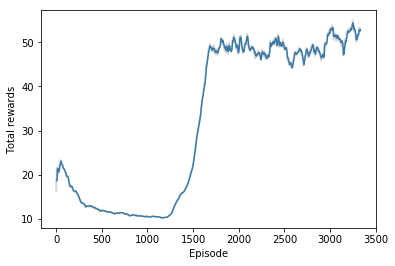

In [19]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

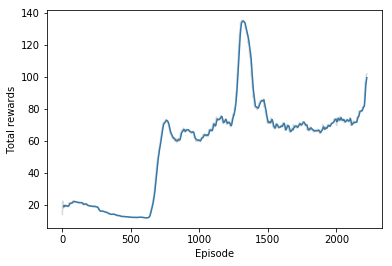

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

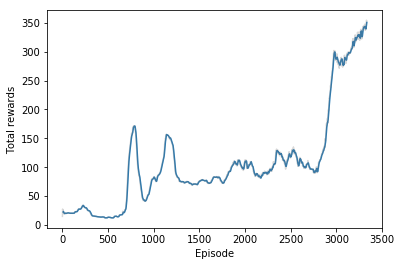

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

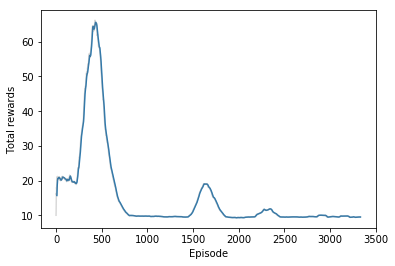

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

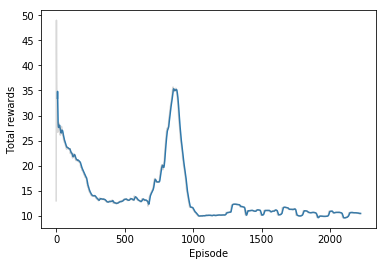

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

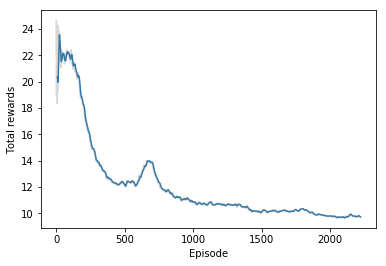

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

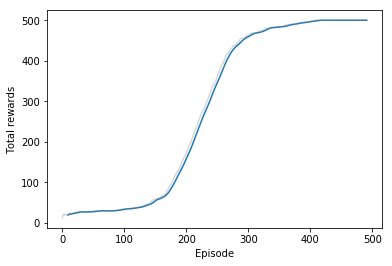

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

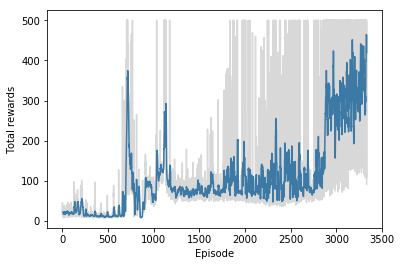

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

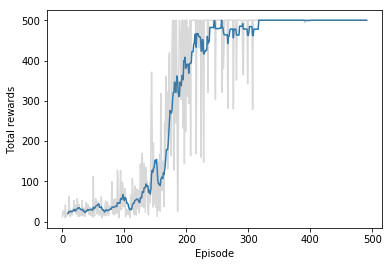

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.